# Module 3 - Algorithm auditing: Accuracy, Fairness and Interpretability 


### Assignment overview

In this assignment, you will be asked to evaluate a set of trained classifiers for accuracy, fairness and transparency. The classifiers have been trained on the [NIJ Recidivism Challenge Dataset](https://nij.ojp.gov/funding/recidivism-forecasting-challenge) to predict whether or not an individual will be arrested for a new crime within 3 years after being released on parole. 

The assignment is modeled after “Accuracy, Fairness, and Interpretability of Machine Learning Criminal Recidivism Models, by Eric Ingram, Furkan Gursoy, Ioannis A. Kakadiaris (https://arxiv.org/abs/2209.14237). 

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Jingyuan Liu (S.N. 69763183)
- Student 2: Nicholas Tam (S.N. 45695970)

### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Describe different fairness metrics, such as statistical parity, equal opportunity and equal accuracy 
2. Discuss fairness and fairness metrics from the perspective of multiple stakeholders 
3. Define objective functions based on fairness metrics  
4. Evaluate a model’s transparency using strategies such as global surrogate models, permutation feature importance, and Shapley Additive Explanations (SHAP) 
5. Evaluate common machine learning models based on their accuracy, fairness and interpretability 
6. Describe how metrics such as accuracy and fairness need to be balanced for a trained model to have acceptable accuracy and low bias 

## Import Libraries:

In [1]:
# Here are some libraries you may need for this exercise, for your convenience
#!pip install scikit-learn==1.1.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
# !pip install xgboost
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    # plot_confusion_matrix, # Depreciated, use ConfusionMatrixDisplay
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


import joblib
from sklearn import tree
from sklearn.inspection import permutation_importance

In [2]:
# !pip install eli5
import eli5

import warnings
warnings.filterwarnings("ignore")

# Part 1: Getting started:

Before starting this assignment, we ask you to read the paper it has been modeled after, to get an idea of the problem we are working on: https://arxiv.org/abs/2209.14237

You can also review the original dataset source [here](https://nij.ojp.gov/funding/recidivism-forecasting-challenge). The website includes a lot of information on the dataset and a detailed description of each of its columns (look for Appendix 2: Codebook).

Now that you have familiarized with the problem, you know that the goal is predicting the binary variable `Recidivism_Within_3years`, which indicates whether or not the person has committed a new felony or misdemeanour within 3 years from the beginning of parole supervision. 

The National Institute of Justice’s (NIJ) obviously would want to deploy a highly accurate predictive model, to make sure that only deserving people get released on parole. Unfortunately, the existence of bias in the training set (typically historical or representation bias) makes it very likely to end up with an unfair classifier, that is, a classifier that produces different results for different protected classes of population.

Your job is to evaluate 5 classifiers, pre-trained and provided to you. This is called **algorithm auditing:** you are not the designer of the model, but you are in charge of evaluating its performance. Algorithm auditing can focus on various metrics and populations of interest, but in this case we will focus on evaluating **accuracy, fairness and transparency** of each algorithm.

To begin, load the datasets and classsifiers by running the cells below:

In [3]:
# Note: these training and test sets do not correspond to the ones on the NIJ's website,
# they are our own partition

train_df = pd.read_csv("training_set.csv")
test_df = pd.read_csv("testing_set.csv")

In [4]:
# Creating training and test sets and separating features and target
X_train, y_train = (
    train_df.drop(columns=["Recidivism_Within_3years"]),
    train_df["Recidivism_Within_3years"],
)
X_test, y_test = (
    test_df.drop(columns=["Recidivism_Within_3years"]),
    test_df["Recidivism_Within_3years"],
)

In [5]:
# Loading classifiers
logreg_model  = joblib.load("models_for_A3/NIJ_logreg.joblib")
rf_model      = joblib.load("models_for_A3/NIJ_rf.joblib")
tree_model    = joblib.load("models_for_A3/NIJ_tree.joblib")
xgboost_model = joblib.load("models_for_A3/NIJ_xgboost.joblib")

[09:44:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667414697403/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



# Part 2: Classifiers' Accuracy (and other performance metrics):

First, we will evaluate each classifier's accuracy, together with other performance metrics that help us understanding how reliable the classifier's answers are. In addition to accuracy, we will use, **precision, recall, F1 score, and Area Under the Curve (AUC).**

### Question 1

can you provide definition and formula for accuracy, precision, recall and F1 score?

It may help you use this table for reference:

<img src="ConfMatrix.png" alt="drawing" width="500"/>

Here, we are giving you the definition of AUC, as a reminder and example (note that the other metrics will need the formula):

**AUC:** AUC stands for Area Under the ROC curve. The ROC (receiver operating characteristic) curve is a plot of the recall and false positive rate of a classifier for different classification thresholds (see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more details). AUC values go between 0 and 1. Higher values are more desirable as they indicate that the classifier is good at avoiding both false positives and false negatives. A value of 0.5 for a binary classification indicates that the classifier is no better at predicting the outcome than random guessing.

**<span style="color:blue">Add remaining definitions and formulas here</span>**
* <span style="color:blue">**Accuracy:** A measure of how often classifier correctly predicts, as a proportion of all predicted instances that are correct between 0 and 1. A higher accuracy indicates that the model's predictions align well with the actual labels for each instance. While this measure is relatively easy to explain, it operates under the assumption that the classes in the population are balanced, and could be misleading if they are not.</span>
    * <span style="color:blue">Formula: $\frac{TP + TN}{TP + FP + FN + TN}$</span>
* <span style="color:blue">**Precision:** The proportion of true positives out of all positive predictions, measured between 0 and 1. A higher precision indicates the model is less likely to provide false positives. It is effective for mitigating issues involving imbalanced classes, and allows for a more direct interpretation for testing false positives (e.g. Minimise risk of email being incorrectly labeled as spam), though it does not account for false negatives in the data.</span>
    * <span style="color:blue">Formula: $\frac{TP}{TP + FP}$</span>
* <span style="color:blue">**Recall:** The proportion of true positives out of all actual positive instances, measured between 0 and 1. It is effective for mitigating issues involving imbalanced classes, and allows for a more direct interpretation for testing false negatives (e.g. Minimise risk of missing disease), though it does not account for false positives in the data.</span> 
    * <span style="color:blue">Formula: $\frac{TP}{TP + FN}$</span>
* <span style="color:blue">**F1 score:** A measure of the harmonic mean of precision and recall. It is effective for mitigating issues involving imbalanced classes, and allows for the model to be tested for high and balanced values of precision and recall. However, it operates under the assumption that both precision and recall have equal weighting in the issue at hand, and does not account for the distribution of errors.</span> 
    * <span style="color:blue">Formula: $\frac{2 * Precision * Recall}{Precision + Recall} = \frac{2TP}{2TP + FP + FN}$</span>
* <span style="color:blue">Sources</span>
    * Evidently AI Team. (n.d.). Accuracy vs. precision vs. recall in machine learning: What’s the difference? Evidently AI - Open-Source ML Monitoring and Observability. https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall#:~:text=Cons%3A,performance%20on%20the%20target%20class.
    * The importance of accuracy in machine learning: A comprehensive guide. The Importance of Accuracy in Machine Learning: A Comprehensive Guide. (n.d.). https://www.artsyltech.com/blog/Accuracy-In-Machine-Learning
    * Kumar, S. (2024, October 8). Metrics to evaluate your classification model to take the right decisions. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/
    * Machine Learning. (2023, September 27). What are the advantages and disadvantages of using F1 score for Ann Performance Evaluation?. F1 Score for ANN Performance Evaluation: Pros and Cons. https://www.linkedin.com/advice/3/what-advantages-disadvantages-using-f1-score-ann 

### Question 2

For every classifier given, calculate and report accuracy, precision, recall, F1 score, and AUC on both training and test set. **For ease of visualization, summarize these results in one or two tables below this question.**

**Hints:** 
- Scikit-learn provides a lot of useful built-in functions to compute performance metrics. You can find them all in the package [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), under Classification Metrics.
- Some classifiers may take longer than others to make their predictions, so you may have to wait a few minutes for a cell to run. More than that, however, likely means something is wrong and needs to be fixed before continuing.

### LogReg Model:

In [6]:
# Compute required metrics here. You may add more cells if needed
data = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc_auc_score": [],
}

def classifier_metrics(modelname, model): 
    data["model"].append(str(modelname) + " " + str("(Training)"))
    data["accuracy"].append(accuracy_score(y_train, model.predict(X_train)))
    data["precision"].append(precision_score(y_train, model.predict(X_train), zero_division=1))
    data["recall"].append(recall_score(y_train, model.predict(X_train)))
    data["f1 score"].append(f1_score(y_train, model.predict(X_train)))
    data["roc_auc_score"].append(roc_auc_score(y_train, model.predict(X_train)))

    data["model"].append(str(modelname) + " " + str("(Testing)"))
    data["accuracy"].append(accuracy_score(y_test, model.predict(X_test)))
    data["precision"].append(precision_score(y_test, model.predict(X_test)))
    data["recall"].append(recall_score(y_test, model.predict(X_test)))
    data["f1 score"].append(f1_score(y_test, model.predict(X_test)))
    data["roc_auc_score"].append(roc_auc_score(y_test, model.predict(X_test)))

In [7]:
data = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc_auc_score": [],
}
classifier_metrics("logreg_model", logreg_model)
df = pd.DataFrame(data)
df

,model,accuracy,precision,recall,f1 score,roc_auc_score
0,logreg_model (Training),0.714610,0.776119,0.716321,0.745022,0.714273
1,logreg_model (Testing),0.701974,0.749397,0.709685,0.729000,0.700825


### Random Forest Model:

In [8]:
# Compute required metrics here. You may add more cells if needed
data = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc_auc_score": [],
}
classifier_metrics("rf_model", rf_model)
df = pd.DataFrame(data)
df

,model,accuracy,precision,recall,f1 score,roc_auc_score
0,rf_model (Training),0.996627,0.999332,0.994870,0.997096,0.996972
1,rf_model (Testing),0.719262,0.721262,0.819781,0.767372,0.704287


### Decision Tree Model:

In [9]:
# Compute required metrics here. You may add more cells if needed
data = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc_auc_score": [],
}
classifier_metrics("tree_model", tree_model)
df = pd.DataFrame(data)
df

,model,accuracy,precision,recall,f1 score,roc_auc_score
0,tree_model (Training),0.738609,0.761806,0.801539,0.781168,0.726252
1,tree_model (Testing),0.697845,0.713596,0.776839,0.743876,0.686077


### XGBoost Model:

In [10]:
# Compute required metrics here. You may add more cells if needed
data = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc_auc_score": [],
}
classifier_metrics("xgboost_model", xgboost_model)
df = pd.DataFrame(data)
df

,model,accuracy,precision,recall,f1 score,roc_auc_score
0,xgboost_model (Training),0.873590,0.867201,0.924378,0.894877,0.863618
1,xgboost_model (Testing),0.735905,0.737228,0.827318,0.779679,0.722287


### Overall:

In [11]:
data = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc_auc_score": [],
}
modellist = ["logreg_model", "rf_model", "tree_model", "xgboost_model"]
modeldict = {"logreg_model": logreg_model, "rf_model": rf_model, "tree_model": tree_model, "xgboost_model": xgboost_model}
for model in modellist: 
    classifier_metrics(model, modeldict[model])
df = pd.DataFrame(data)
df

,model,accuracy,precision,recall,f1 score,roc_auc_score
0,logreg_model (Training),0.714610,0.776119,0.716321,0.745022,0.714273
1,logreg_model (Testing),0.701974,0.749397,0.709685,0.729000,0.700825
2,rf_model (Training),0.996627,0.999332,0.994870,0.997096,0.996972
3,rf_model (Testing),0.719262,0.721262,0.819781,0.767372,0.704287
4,tree_model (Training),0.738609,0.761806,0.801539,0.781168,0.726252
5,tree_model (Testing),0.697845,0.713596,0.776839,0.743876,0.686077
6,xgboost_model (Training),0.873590,0.867201,0.924378,0.894877,0.863618
7,xgboost_model (Testing),0.735905,0.737228,0.827318,0.779679,0.722287


### Question 3

For every classifier given, plot the confusion matrices on training and test set. Here is another function you will find helpful for this task: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

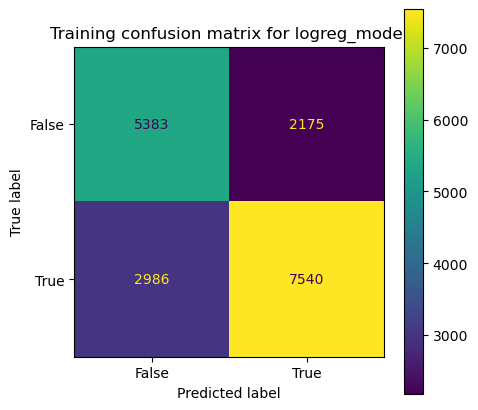

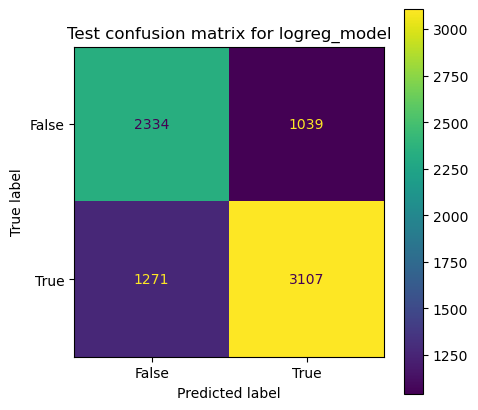

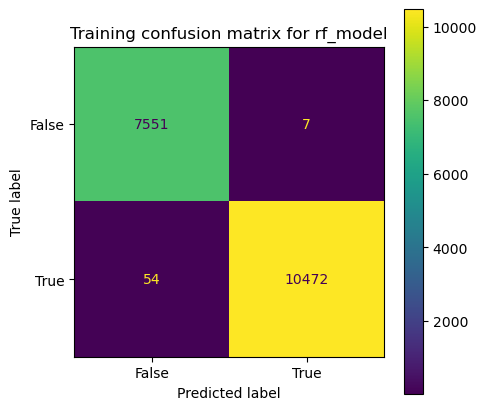

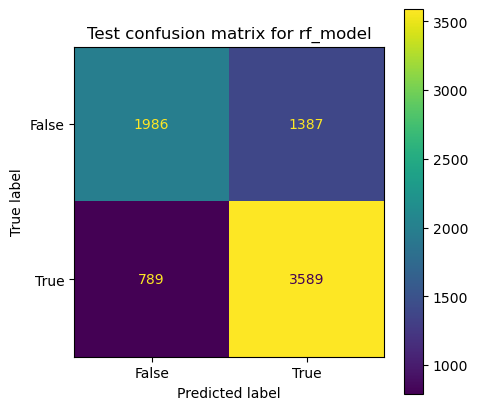

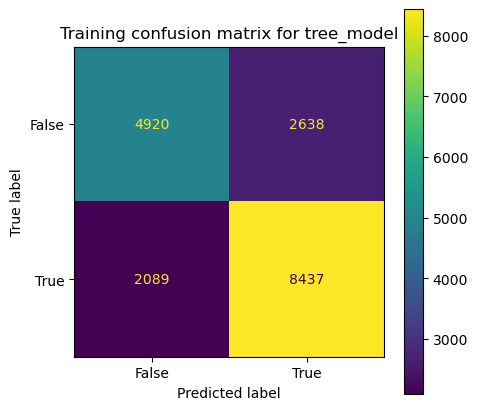

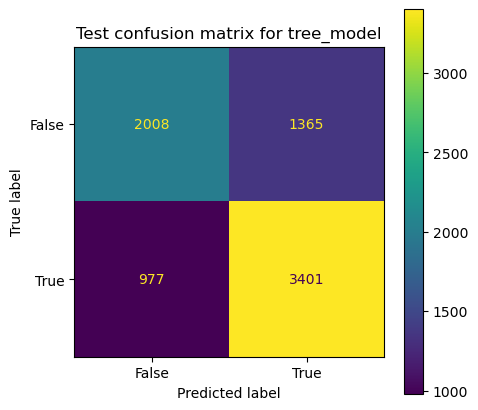

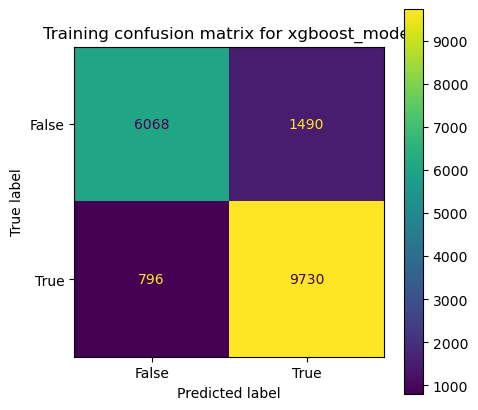

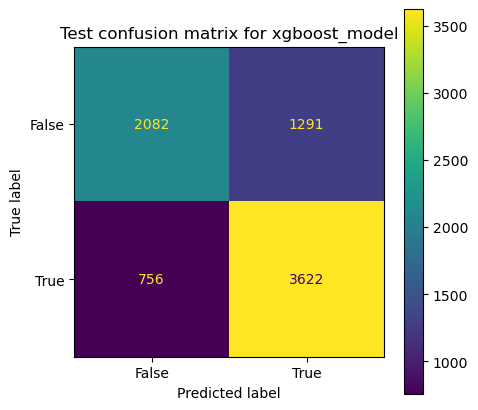

In [12]:
# Output confusion matrices here. You may add more cells if needed
modellist = ["logreg_model", "rf_model", "tree_model", "xgboost_model"]
modeldict = {"logreg_model": logreg_model, "rf_model": rf_model, "tree_model": tree_model, "xgboost_model": xgboost_model}

for modelname in modellist: 
    fig, ax = plt.subplots(figsize=(5, 5))
    cm_train = ConfusionMatrixDisplay.from_estimator(
        modeldict[modelname], X_train, y_train, values_format="d", ax = ax
    )
    cm_train.ax_.set_title("Training confusion matrix for " + modelname)
    fig, ax = plt.subplots(figsize=(5, 5))
    cm_test = ConfusionMatrixDisplay.from_estimator(
        modeldict[modelname], X_test, y_test, values_format="d", ax = ax
    )
    cm_test.ax_.set_title("Test confusion matrix for " + modelname)

### Question 4

Based on the results obtained so far, answer the following questions, providing an explanation and trying to base your decision on multiple metrics:
- Which classifiers would you choose for deployment?
    - <span style="color:blue">Given the problem, minimising the risk of both false positives and negatives would be most ideal, as false positives would cause individuals who wish to atone to be treated unjustly, and false negatives would lead to unrepentant criminals being released and allowed to recidivate. While each model provides relatively similar testing results, `logreg_model` and `tree_model` both provide smaller differences in training and testing scores. `logreg_model` provides a better testing `roc_auc_score` and less false positives, while `tree_model` provides better training and testing `f1 score` and less false negatives. Given that our main focus is on the positive class of `Recidivism_Within_3years`, a greater `f1 score` would be more important, and thus we would consider the classifier `tree_model` to be the most effective model for deployment.</span>
- Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?
    - <span style="color:blue">The most "severe" classifier is the one that provides the greatest proportion of True predictions, regardless of whether they are actually True or False. According to the testing confusion matrices, `logreg_model` provides the greatest proportion of True predictions and thus is the most "severe".</span>
- Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?
    - <span style="color:blue">The most cautious classifier is the one that provides the greatest proportion of False predictions, regardless of whether they are actually True or False. According to the testing confusion matrices, `rf_model` provides the greatest proportion of False predictions and thus is the most cautious.</span>
- <span style="color:blue">Czakon, J. (2024, September 10). F1 score vs ROC AUC vs Accuracy Vs PR AUC: Which evaluation metric should you choose?. neptune.ai. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc</span>

# Part 3 :  Fairness Evaluation:

Now that we have an understanding of how accurate our classifiers are across all samples, we need to measure their *fairness* across different categories. In similar problems, we are typically concerned with the classifiers being fair across different segments of protected populations (e.g. different genders or ethnicities). The original paper evaluates fairness for both gender and race, but for the purpose of this exercise we will only look at fairness across race, that is, for White and Black defendants.

### Question 5

As we have seen in class, there is not just one fairness metric, but several, as they have different ways to identify different treatments across populations. The metrics used in the paper, which you will have to replicate, are:

1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

Before jumping into code writing, we must make sure that we have a solid understanding of how these metrics are computed from the True Positive, True Negative, False Positive, and False Negative values *for each group*. We will add the subscript *b* and *w* when appropriate to identify metrics from the group of black or white defendants, respectively. Then, we will write the equations for all fairness metrics. The first one is provided to you as an example:

| Metric    | Formula |
| :-------- | :------- |
| PPRD  |  $\frac{TP_b + FP_b}{TP_w + FP_w}$  |
| PPGRD | <span style="color:blue">$\frac{(TP_b + FP_b)/(TP_b + FP_b + TN_b + FN_b)}{(TP_w + FP_w)/(TP_w + FP_w + TN_w + FN_w)} = \frac{(TP_b + FP_b)(TP_w + FP_w + TN_w + FN_w)}{(TP_w + FP_w)(TP_b + FP_b + TN_b + FN_b)}$</span> |
| FDRD | <span style="color:blue">$\frac{(FP_b)/(TP_b + FP_b)}{(FP_w)/(TP_w + FP_w)} = \frac{(FP_b)(TP_w + FP_w)}{(FP_w)(TP_b + FP_b)}$</span> |
| FPRD | <span style="color:blue">$\frac{(FP_b)/(TN_b + FP_b)}{(FP_w)/(TN_w + FP_w)} = \frac{(FP_b)(TN_w + FP_w)}{(FP_w)(TN_b + FP_b)}$</span> |
| FORD | <span style="color:blue">$\frac{(FN_b)/(TN_b + FN_b)}{(FN_w)/(TN_w + FN_w)} = \frac{(FN_b)(TN_w + FN_w)}{(FN_w)(TN_b + FN_b)}$</span> |
| FNRD | <span style="color:blue">$\frac{(FN_b)/(TP_b + FN_b)}{(FN_w)/(TP_w + FN_w)} = \frac{(FN_b)(TP_w + FN_w)}{(FN_w)(TP_b + FN_b)}$</span> |

Finally, the paper also computes an **Average Distance from Reference** across all the above metrics. This helps us summarizing the fairness of a classifier in a single number. Compute the Average Distance from Reference for all the classifiers, knowing that the reference is 1 (i.e. a score of 1 indicates perfect fairness). Use tha absolute value to compute the distance from the reference (e.g. a FDRD score of 0.80 and one of 1.20 both have a distance from the reference of 0.20).

Now that you have a better understanding of how to compute these metrics, do so for all the classifiers, both on the training and the test sets.

**Hints:**
- There are several ways to write Python code to easily compute the fairness metrics we want. If you have trouble starting, talk with a TA or with the instructor during our in-class work time or office hours to come up with a plan. 
- Instead of copy-pasting code, it is definitely a good idea to create one or more functions to compute the fairness metrics. Writing functions in Python is very easy! If you are new to it, start [here](https://www.geeksforgeeks.org/python-functions/) (stop before Arbitrary Keyword Arguments), and of course, come to us for more help!

In [13]:
# Add as many cells as needed to compute the required metrics for every classifier. You may
# also add markdown cells if you want to add comments or notes about your results.
train_df_b = train_df[train_df["Race"] == "BLACK"]
train_df_w = train_df[train_df["Race"] == "WHITE"]
test_df_b = test_df[test_df["Race"] == "BLACK"]
test_df_w = test_df[test_df["Race"] == "WHITE"]
# train_df_b.head()

# Creating training and test sets and separating features and target
X_train_b, y_train_b = (
    train_df_b.drop(columns=["Recidivism_Within_3years"]),
    train_df_b["Recidivism_Within_3years"],
)
X_test_b, y_test_b = (
    test_df_b.drop(columns=["Recidivism_Within_3years"]),
    test_df_b["Recidivism_Within_3years"],
)
X_train_w, y_train_w = (
    train_df_w.drop(columns=["Recidivism_Within_3years"]),
    train_df_w["Recidivism_Within_3years"],
)
X_test_w, y_test_w = (
    test_df_w.drop(columns=["Recidivism_Within_3years"]),
    test_df_w["Recidivism_Within_3years"],
)

In [14]:
# https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python

cm_mets = {
    "model": [],
    # "PPRD": [],
    # "PPGRD": [],
    # "FDRD": [],
    # "FPRD": [],
    # "FORD": [],
    # "FNRD": [],
    "PPRD_adfr": [],
    "PPGRD_adfr": [],
    "FDRD_adfr": [],
    "FPRD_adfr": [],
    "FORD_adfr": [],
    "FNRD_adfr": [],
}

def cm_metrics(modelname, model, X_b, y_b, X_w, y_w, name):
    # cm = ConfusionMatrixDisplay.from_estimator(
    #     model, X_train, y_train, values_format="d"
    # ).confusion_matrix 

    cm_b = confusion_matrix(y_b, model.predict(X_b))
    cm_w = confusion_matrix(y_w, model.predict(X_w))
    
    TP_b = cm_b[0][0] 
    FP_b = cm_b[0][1] 
    FN_b = cm_b[1][0] 
    TN_b = cm_b[1][1] 

    TP_w = cm_w[0][0] 
    FP_w = cm_w[0][1] 
    FN_w = cm_w[1][0] 
    TN_w = cm_w[1][1] 

    PPRD = (TP_b + FP_b)/(TP_w + FP_w)
    PPGRD = ((TP_b + FP_b)/(TP_b + FP_b + FN_b + TN_b))/((TP_w + FP_w)/(TP_w + FP_w + FN_w + TN_w))
    FDRD = (FP_b/(TP_b + FP_b))/(FP_w/(TP_w + FP_w))
    FPRD = (FP_b/(TN_b + FP_b))/(FP_w/(TN_w + FP_w))
    FORD = (FN_b/(TN_b + FN_b))/(FN_w/(TN_w + FN_w))
    FNRD = (FN_b/(TP_b + FN_b))/(FN_w/(TP_w + FN_w))

    PPRD_adfr = abs(PPRD - 1)
    PPGRD_adfr = abs(PPGRD - 1)
    FDRD_adfr = abs(FDRD - 1)
    FPRD_adfr = abs(FPRD - 1)
    FORD_adfr = abs(FORD - 1)
    FNRD_adfr = abs(FNRD - 1)

    cm_mets["model"].append(str(modelname) + " (" + str(name) + ")")
    # cm_mets["PPRD"].append(PPRD)
    # cm_mets["PPGRD"].append(PPGRD)
    # cm_mets["FDRD"].append(FDRD)
    # cm_mets["FPRD"].append(FPRD)
    # cm_mets["FORD"].append(FORD)
    # cm_mets["FNRD"].append(FNRD)
    cm_mets["PPRD_adfr"].append(PPRD_adfr)
    cm_mets["PPGRD_adfr"].append(PPGRD_adfr)
    cm_mets["FDRD_adfr"].append(FDRD_adfr)
    cm_mets["FPRD_adfr"].append(FPRD_adfr)
    cm_mets["FORD_adfr"].append(FORD_adfr)
    cm_mets["FNRD_adfr"].append(FNRD_adfr)

In [15]:
modeldict = {"logreg_model": logreg_model, "rf_model": rf_model, "tree_model": tree_model, "xgboost_model": xgboost_model}
modellist = ["logreg_model", "rf_model", "tree_model", "xgboost_model"]

for modelname in modellist: 
    cm_metrics(modelname, modeldict[modelname], X_train_b, y_train_b, X_train_w, y_train_w, "Training")
    cm_metrics(modelname, modeldict[modelname], X_test_b, y_test_b, X_test_w, y_test_w, "Testing")

cm_mets_df = pd.DataFrame(cm_mets)
cm_mets_df

,model,PPRD_adfr,PPGRD_adfr,FDRD_adfr,FPRD_adfr,FORD_adfr,FNRD_adfr
0,logreg_model (Training),0.271716,0.052716,0.213997,0.060968,0.059559,0.072639
1,logreg_model (Testing),0.294558,0.056298,0.166160,0.027451,0.035063,0.091346
2,rf_model (Training),0.271716,0.052716,0.965847,0.792561,0.319480,0.445670
3,rf_model (Testing),0.294558,0.056298,0.179099,0.022388,0.130365,0.056076
4,tree_model (Training),0.271716,0.052716,0.225651,0.060007,0.126143,0.046944
5,tree_model (Testing),0.294558,0.056298,0.213249,0.043059,0.102355,0.086773
6,xgboost_model (Training),0.271716,0.052716,0.320936,0.156987,0.187694,0.041546
7,xgboost_model (Testing),0.294558,0.056298,0.109142,0.000879,0.002636,0.132486


### Question 6

Based on the results obtained so far, answer the following questions, providing an explanation for each answer:
- Which model exhibits the least amount of bias? 
- Which one is the worse?
- Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?
- Finally, based on the fairness results, which model would you pick for this application? 

* <span style="color:blue">`xgboost_model` exhibits the least amount of bias, providing the least amount of distance from the reference for `FDRD_adfr`, `FPRD_adfr`, and `FORD_adfr`, though it provides the most amount of distance from the reference for `FNRD_adfr`.</span>
* <span style="color:blue">`tree_model` exhibits the most amount of bias, providing the most amount of distance from the reference for `FDRD_adfr`, `FPRD_adfr`, and `FNRD_adfr`, while providing the second greatest amount of distance from the reference for `FORD_adfr`.</span>
* <span style="color:blue">Given that the application is for the the identification of across populations of race, measurement bias will likely occur to the detriment of Black defendants. As such, the fairness metrics `FDRD_adfr` and `FPRD_adfr`</span>
* <span style="color:blue">TEXT</span>

# Part 4: Interpretability Evaluation:

Finally, we will evaluate the *interpretability* of our models. It is important to be able to explain how the model uses each feature to make its predictions and *why* a model has given a particular response for an individual - especially important when, like in this case, people's lives are being affected.

### Inherently Interpretable Models

Some models are known to be *inherently interpretable*, meaning we can decifer the model behavior by looking at its parameters. These models are also called "white-box" models. Logistic regression models and decision trees - in some cases - fall in this category.

### Question 7

Run the cells below and look at the weights of the logistic regression model. For simplicity, the cells below show the 10 most positive and 10 most negative coefficients. What features bring the prediction more toward the positive class? What other features push the prediction toward the negative class? Do you see any coefficients that may be unfairly influencing the decision?

In [16]:
feature_names = np.array(logreg_model.named_steps['columntransformer'].get_feature_names_out())
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

In [17]:
coeff_df_sorted.head(10)

,Coefficient
pipeline-2__Gang_Affiliated_True,0.777355
pipeline-2__Age_at_Release_18-22,0.769491
pipeline-2__Delinquency_Reports_1,0.635838
pipeline-2__Age_at_Release_23-27,0.488772
pipeline-2__Prior_Arrest_Episodes_Felony_0,0.473405
pipeline-2__Gender_M,0.458260
passthrough__Prior_Revocations_Parole,0.362398
passthrough__Condition_MH_SA,0.359117
pipeline-1__Jobs_Per_Year,0.312944
pipeline-2__Prison_Years_Less than 1 year,0.307459


In [18]:
coeff_df_sorted.tail(10)

,Coefficient
pipeline-2__Delinquency_Reports_3,-0.205489
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,-0.216048
pipeline-2__Age_at_Release_38-42,-0.235466
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.249548
pipeline-2__Age_at_Release_43-47,-0.350821
pipeline-2__Program_Attendances_10 or more,-0.385809
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.501982
pipeline-2__Delinquency_Reports_4 or more,-0.507616
pipeline-1__Percent_Days_Employed,-0.663686
pipeline-2__Age_at_Release_48 or older,-0.752269


<span style="color:blue">The features `pipeline-2__Gang_Affiliated_True`, `pipeline-2__Age_at_Release_18-22`, `pipeline-2__Delinquency_Reports_1`, `pipeline-2__Age_at_Release_23-27`, `pipeline-2__Prior_Arrest_Episodes_Felony_0`, `pipeline-2__Gender_M`, `passthrough__Prior_Revocations_Parole`, `passthrough__Condition_MH_SA`, `pipeline-1__Jobs_Per_Year` and `pipeline-2__Prison_Years_Less than 1 year` bring the prediction towards the positive class. 
<br><br> 
The features `pipeline-2__Delinquency_Reports_3`, `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0`, `pipeline-2__Age_at_Release_38-42`, `pipeline-2__Prior_Arrest_Episodes_Felony_2`, `pipeline-2__Age_at_Release_43-47`, `pipeline-2__Program_Attendances_10 or more`, `pipeline-2__Prior_Arrest_Episodes_Felony_1`, `pipeline-2__Delinquency_Reports_4 or more`, `pipeline-1__Percent_Days_Employed`, and `pipeline-2__Age_at_Release_48 or older` bring the prediction towards the negative class.
<br><br> 
The coefficients that may be unfairly influencing the decision are `pipeline-2__Age_at_Release_18-22`, `pipeline-2__Age_at_Release_23-27`, `pipeline-2__Prior_Arrest_Episodes_Felony_0`, `pipeline-2__Gender_M`, `passthrough__Prior_Revocations_Parole`, `passthrough__Condition_MH_SA`, `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0`, `pipeline-2__Age_at_Release_38-42`, `pipeline-2__Prior_Arrest_Episodes_Felony_2`, `pipeline-2__Age_at_Release_43-47`, `pipeline-2__Program_Attendances_10 or more`, `pipeline-2__Prior_Arrest_Episodes_Felony_1`, and `pipeline-2__Age_at_Release_48 or older`.
</span>

### Question 8

Now, let's look at a particular sample and try to explain its prediction. We have picked this sample because its feature values make it a hard case, one very close to the threshold between positive and negative class:

In [19]:
hard_sample = X_test[106:107]

If you look at the ground truth for this sample (try `y_test[106:107]`) you will see that this person has not, in fact, committed a new crime within 3 years from release. But what is the prediction of the logistic regression model? Find the answer and comment below:

In [20]:
# Your answer here
display(y_test[106:107])
display(logreg_model.predict(hard_sample)) # Prediction of logistic regression model: False
display(hard_sample.T)

106    False
Name: Recidivism_Within_3years, dtype: bool

array([False])

,106
Unnamed: 0,5645
ID,5788
Gender,F
Race,WHITE
Age_at_Release,48 or older
Residence_PUMA,3
Gang_Affiliated,NaN
Supervision_Risk_Score_First,6.0
Supervision_Level_First,High
Education_Level,At least some college


Take a closer look at the feature values for this sample. What seems to have contributed the most to the final prediction? What feature pushed the most in the opposite direction?

<span style="color:blue">The feature `pipeline-2__Age_at_Release_48 or older` appears to have contributed the most to the final prediction of `Recidivism_Within_3years == False`. The feature `passthrough__Condition_MH_SA` pushed the most in the opposite direction.</span>

### Question 9
We said that decision trees are also inherently interpretable - *potentially*. That is because, in theory, it is possible to look at the tree structure and to follow the path along the tree to see how each node influenced the decision. But this is only possible if the tree has a reasonably small size.

Run the cell below and see if you can tell what are the most influencial features in the decision tree model.

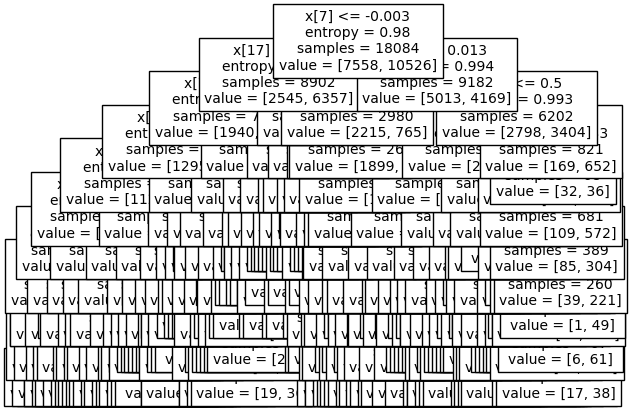

<Figure size 1000x600 with 0 Axes>

In [21]:
tree.plot_tree(tree_model["dt"],fontsize=10)
plt.figure(figsize=(10,6))
plt.show()

If the method above was not satisfactory, you can try visualizing all the rules of the decision tree as text. Is this any better?

In [22]:
from sklearn.tree import export_text
tree_rules = export_text(tree_model.named_steps['dt'], feature_names=list(tree_model.named_steps['ct'].get_feature_names_out()))
print(tree_rules)

|--- pipeline-1__Percent_Days_Employed <= -0.00
|   |--- pipeline-2__Age_at_Release_48 or older <= 0.50
|   |   |--- pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0 <= 0.50
|   |   |   |--- pipeline-2__Gang_Affiliated_True <= 0.50
|   |   |   |   |--- pipeline-2__Prior_Arrest_Episodes_Misd_6 or more <= 0.50
|   |   |   |   |   |--- pipeline-1__Supervision_Risk_Score_First <= 0.20
|   |   |   |   |   |   |--- pipeline-1__Percent_Days_Employed <= -1.15
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M <= 0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M >  0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Conviction_Episodes_Prop_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Arre

When it is not possible to interpret a decision tree because of its complex structure, we can still extract other information from it that will help us understand the features' importance in the decision. The code in the cell below extracts the feature importances from the model (line 3), then uses this information to create a bar plot of features sorted by importance. The feature importance extracted this way is based on [Gini Importance](https://www.codecademy.com/article/fe-feature-importance-final) (as it is done in the original paper), which reflects how the features were picked when building the decision tree.

<Axes: >

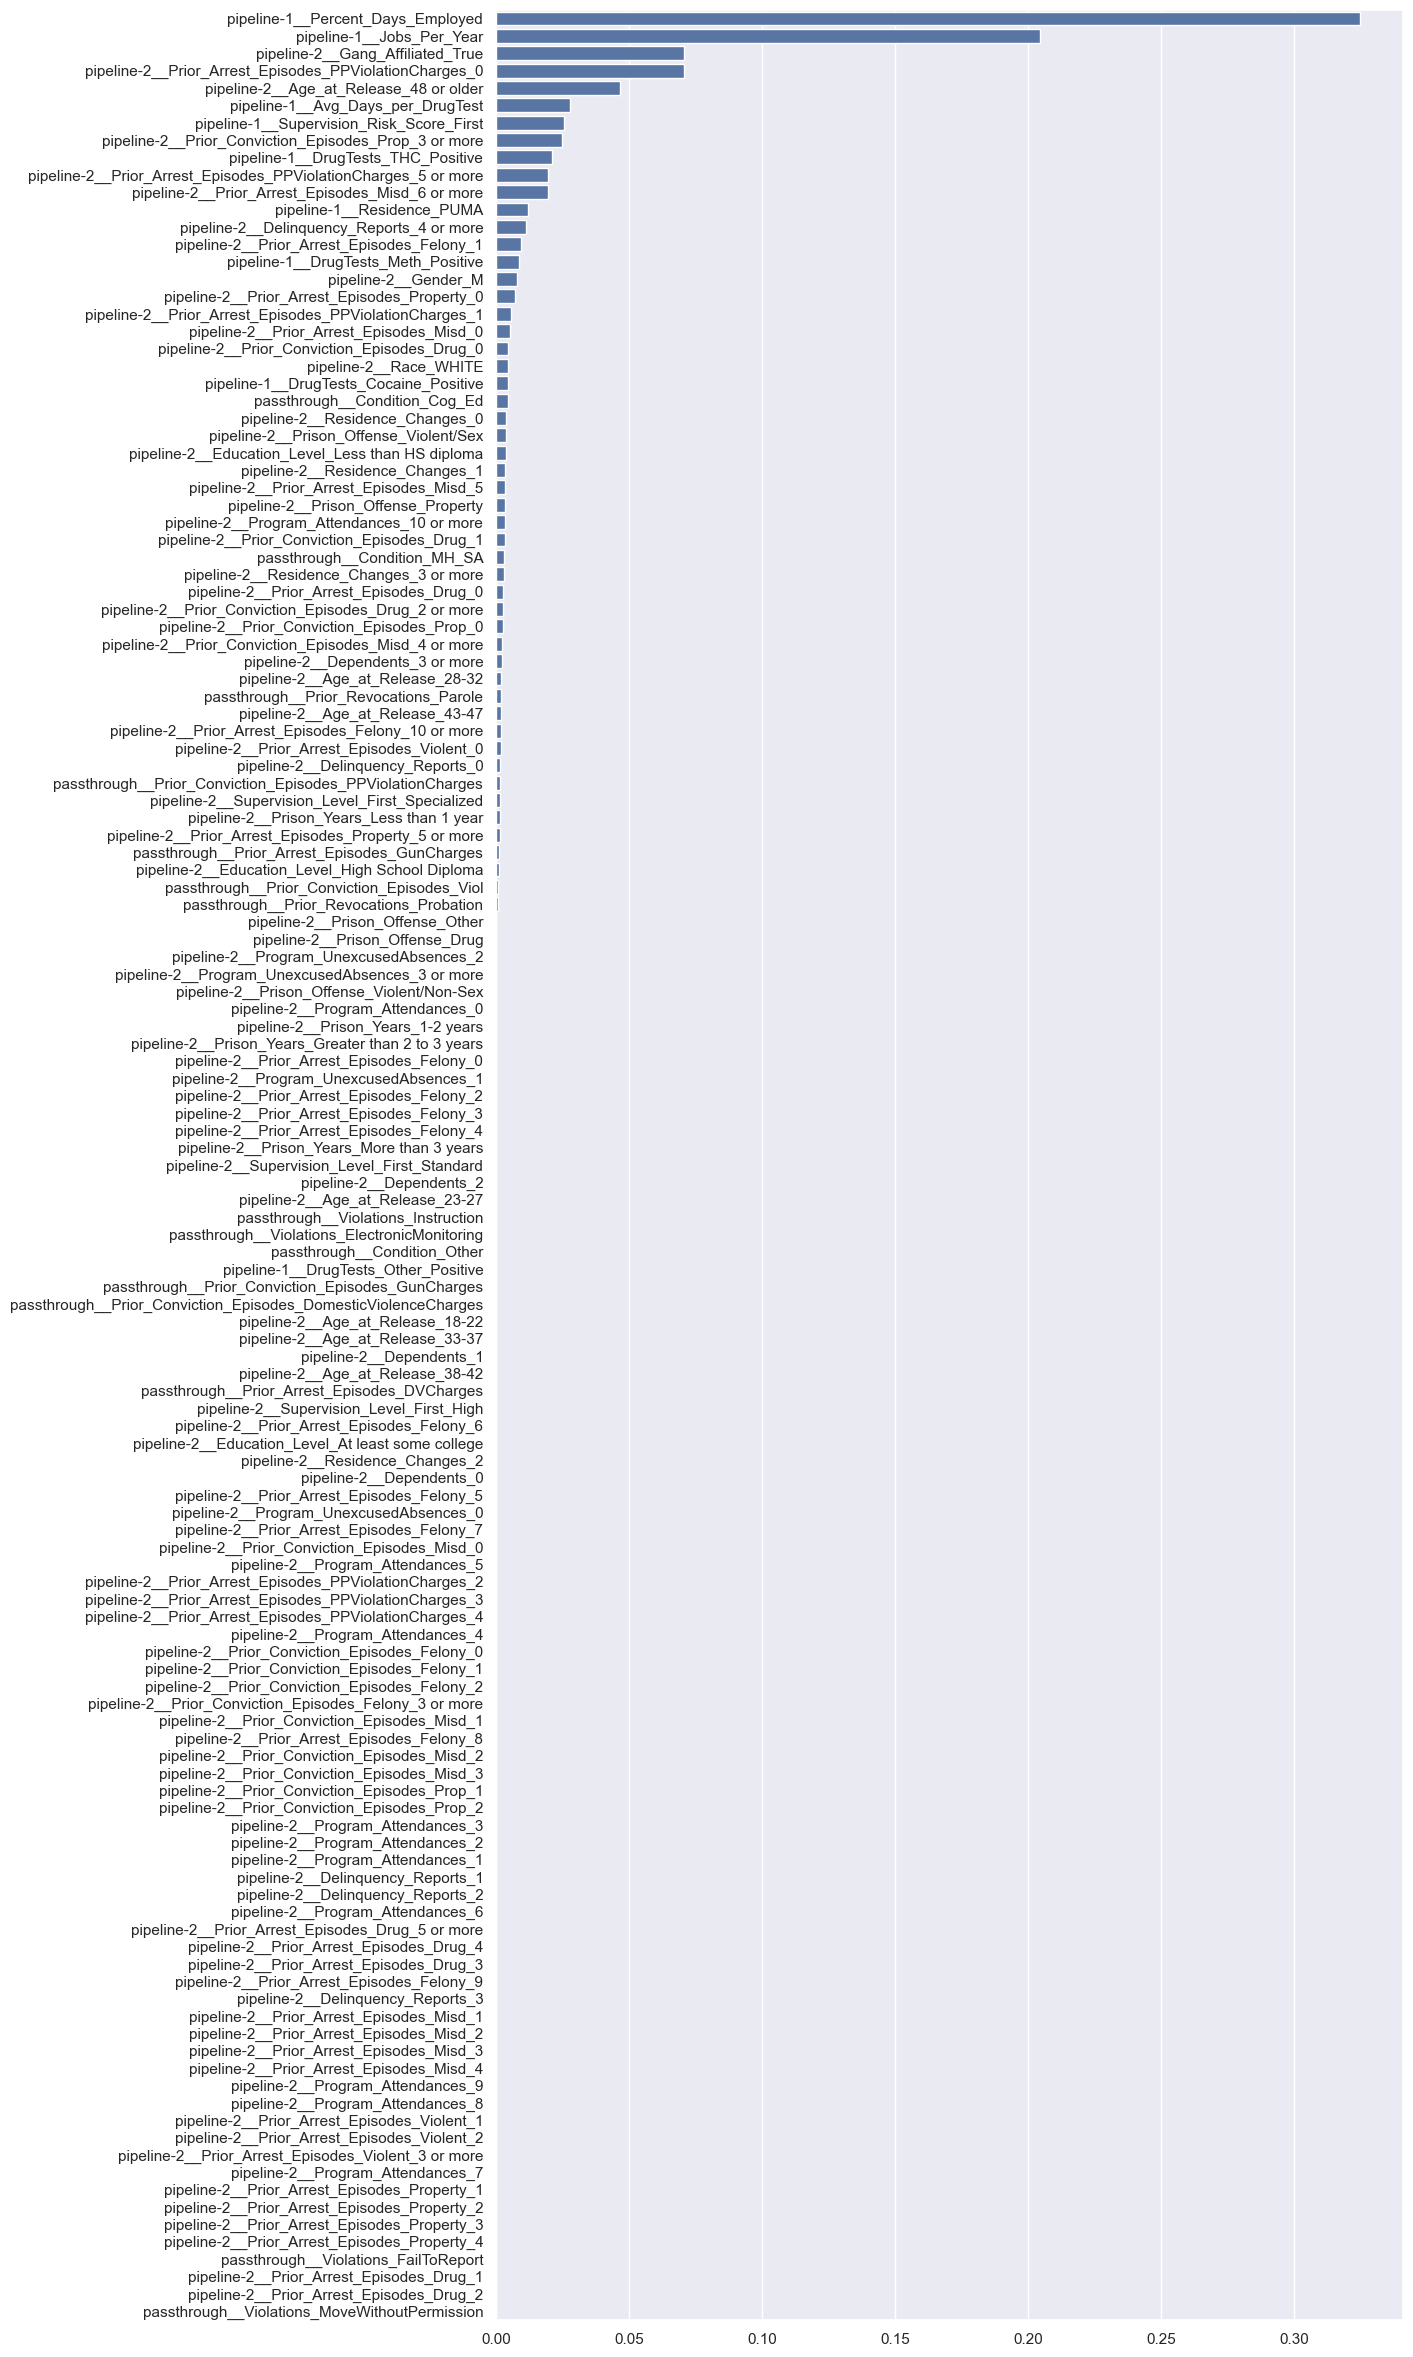

In [23]:
import seaborn as sns

feature_importances = tree_model.named_steps["dt"].feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

Comment on the features importance of the tree model, compared to those seen in the logistic regression model, as well as the original paper results. Also, **what is a big limitation of using feature importance, compared to observing the coefficient of the logistic regression model?**

<span style="color:blue">According to the features importance of `tree_model`, the features `pipeline-1__Percent_Days_Employed`, `pipeline-1__Jobs_Per_Year`, `pipeline-2__Gange_Affiliated_True`, `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0`, `pipeline-2__Age_at_Release_48 or older`, `pipeline-1__Avg_Days_per_DrugTest`, `pipeline-1__Supervision_Risk_Score_First`, `pipeline-2__Prior_Conviction_Episodes_Prop_3 or more`, `pipeline-1__DrugTests_THC_Positive`, `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more` and `pipeline-2__Prior_Arrest_Episodes_Misd_6 or more` contribute the most to the classification of samples in the model. Of these features, `pipeline-1__Percent_Days_Employed`, `pipeline-1__Jobs_Per_Year`, `pipeline-2__Gange_Affiliated_True`, `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0`, and `pipeline-2__Age_at_Release_48 or older` are among the features in the logistic regression model with the most extreme coefficients as shown in Q7. `pipeline-1__Percent_Days_Employed` and `pipeline-2__Gange_Affiliated_True` provide very strong contributions to the prediction for both models, `pipeline-1__Jobs_Per_Year` and `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0` provide relatively stronger contributions to `tree_model`, while `pipeline-2__Age_at_Release_48 or older` provides a relatively stronger contribution to `logreg_model`. A big limitation of feature importance compared to observing coefficients is that it does not provide a direct measure of how the features will influence the model prediction, making it more difficult to interpret in comparison.</span>
* <span style="color:blue"> https://www.codecademy.com/article/fe-feature-importance-final</span>

### Question 10

As before, we are interested in evaluating how the model classifies a particular sample. Let's start looking at the classification for our `hard_sample`. Is it correct?

In [24]:
# Your answer here: The classification is incorrect
display(y_test[106:107]) # False
display(tree_model.predict(hard_sample)) # True

106    False
Name: Recidivism_Within_3years, dtype: bool

array([ True])

We would like to be able to tell what sequence of rules has led to this final decision, but, for a tree this large, this can be difficult, unless we want to manually sift through the list of rules or write some elaborate custom code. In the next sections, we will see an alternative method (SHAP) to achieve this result.

### Question 11: Evaluation of Non-inherently Interpretable Models Using a Surrogate Model

Models that are not inherently interpretable ("black box" models) can still be examined to understand how they used the available features to make their predictions. In fact, there are many strategies to do this. The first one we are going to see is through use of a **surrogate model.** In this case, we train another model - an inherently interpretable one, such as a logistic regressor - on the *predictions* of the black box model, and then we try to interpret *its parameters*. Let's complete the code below to do that on the two non-inherently interpretable models included in this exercise: the Random Forest and XGBoost.

#### Surrogate for Random Forest Model

In [89]:
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

# surrogate_model_rf = joblib.load("NIJ_logreg.joblib")
surrogate_model_rf = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set
surrogate_model_rf.fit(X_train, tree_model.predict(X_train))

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model
s_feature_names = np.array(surrogate_model_rf.named_steps['columntransformer'].get_feature_names_out())
s_coeffs = surrogate_model_rf.named_steps["logisticregression"].coef_.flatten()
s_coeff_df = pd.DataFrame(s_coeffs, index=s_feature_names, columns=["Coefficient"])
s_coeff_df_sorted = s_coeff_df.sort_values(by="Coefficient", ascending=False)
display(s_coeff_df_sorted.head(10))
display(s_coeff_df_sorted.tail(10))

,Coefficient
pipeline-2__Gang_Affiliated_True,1.981884
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,1.090830
pipeline-1__Jobs_Per_Year,0.626207
pipeline-2__Age_at_Release_18-22,0.592761
pipeline-2__Age_at_Release_23-27,0.510936
pipeline-2__Gender_M,0.441204
pipeline-2__Delinquency_Reports_1,0.431845
pipeline-2__Prior_Conviction_Episodes_Prop_3 or more,0.425607
pipeline-2__Prior_Arrest_Episodes_Misd_6 or more,0.346842
pipeline-2__Residence_Changes_3 or more,0.346202


,Coefficient
pipeline-2__Prior_Conviction_Episodes_Prop_1,-0.180564
pipeline-2__Program_Attendances_10 or more,-0.183690
pipeline-2__Prison_Years_More than 3 years,-0.196347
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.212103
pipeline-2__Prior_Arrest_Episodes_Misd_0,-0.274397
pipeline-2__Delinquency_Reports_4 or more,-0.575022
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.634692
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,-0.949615
pipeline-2__Age_at_Release_48 or older,-1.330968
pipeline-1__Percent_Days_Employed,-1.743467


In [111]:
display(
    set(coeff_df_sorted.head(10).index.values.tolist()).intersection(s_coeff_df_sorted.head(10).index.values.tolist()) 
    # - (set(coeff_df_sorted.head(10).index.values.tolist()) - set(s_coeff_df_sorted.head(10).index.values.tolist()))
)
display(
    set(coeff_df_sorted.tail(10).index.values.tolist()).intersection(s_coeff_df_sorted.tail(10).index.values.tolist()) 
    # - (set(coeff_df_sorted.tail(10).index.values.tolist()) - set(s_coeff_df_sorted.tail(10).index.values.tolist()))
)

{'pipeline-1__Jobs_Per_Year',
 'pipeline-2__Age_at_Release_18-22',
 'pipeline-2__Age_at_Release_23-27',
 'pipeline-2__Delinquency_Reports_1',
 'pipeline-2__Gang_Affiliated_True',
 'pipeline-2__Gender_M'}

{'pipeline-1__Percent_Days_Employed',
 'pipeline-2__Age_at_Release_48 or older',
 'pipeline-2__Delinquency_Reports_4 or more',
 'pipeline-2__Prior_Arrest_Episodes_Felony_1',
 'pipeline-2__Prior_Arrest_Episodes_Felony_2',
 'pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0',
 'pipeline-2__Program_Attendances_10 or more'}

Now that we have the weights of the surrogate model, what can we say about how the Random Forest model makes its predictions? What features seem more important? Are they similar to what we have seen for the other models so far?

<span style="color:blue"> In `surrogate_model_rf`, the features `pipeline-1__Percent_Days_Employed`, `pipeline-2__Age_at_Release_48 or older`, `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0`, `pipeline-2__Gange_Affiliated_True`, `pipeline-1__Jobs_Per_Year` and `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more` are the primary characteristics that influence the prediction, as `surrogate_model_rf` has significant increases in their corresponding absolute weight values compared to the weights of `logreg_model`. `pipeline-1__Percent_Days_Employed`, `pipeline-2__Age_at_Release_48 or older` and `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0` push the prediction towards `Recidivism_Within_3years == False`, while `pipeline-2__Gange_Affiliated_True`, `pipeline-1__Jobs_Per_Year` and `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more` push the prediction towards `Recidivism_Within_3years == True`. The greater weights of `surrogate_model_rf` correspond to the higher levels of feature importances indicated by the bar plot of Gini importance.
</span>

**Note:** using a surrogate model is not always a very good strategy, because the simpler "white box" model is often unable to replicate the behavior of the most complex "black box" model. We can get a sense of how close the surrogate is approximating the original model by looking at the R<sup>2</sup> score. In the paper, they do so when trying to create a surrogate for XGBoost, and they explain: 

*The R<sup>2</sup> value between the XGBoost predictions and the surrogate model predictions on the test set is 0.38. The surrogate model only explains 38% of the variance in the XGBoost model’s predictions*

Test this for the random forest surrogate model. How much variance is it able to capture?

**Hints:**
- Think carefully about what constitues the array of predictions and the array of ground truths in this case
- You may remember that R<sup>2</sup> is, in fact, a metric for regression, not for classification! How can we use R<sup>2</sup> in this case? There are various ways to approximate R<sup>2</sup> for classification, as explained [here](https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html). We will use the simplest one and use **count R<sup>2</sup>**, which is simply the accuracy of the surrogate classifier

In [51]:
# Your answer here
def get_num_correct(y, y_pred, t=0.5):
    y_correct = np.array([0.0 if p < t else 1.0 for p in y_pred])
    return sum([1.0 for p, p_pred in zip(y, y_correct) if p == p_pred])

def count_rsquare(y, y_pred, t=0.5):
    n = float(len(y))
    num_correct = get_num_correct(y, y_pred, t)
    return num_correct / n

In [52]:
# 0.7043795620437956 of the variance is captured by the surrogate model
count_rsquare(y_train, surrogate_model_rf.predict(X_train))

0.7043795620437956

Now, repeat the analysis through surrogate model for XGBoost. Comment on the results, including considerations on the following:
- What seem to be the most important features?
- How do the sets of most important features compare across models (do not forget logistic regression and decision tree in this comparison)?
- How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?
- ...more thoughts of your choice...

#### Surrogate for XGBoost Model

In [50]:
# Your answer here
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

surrogate_model_xgboost = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set
surrogate_model_xgboost.fit(X_train, xgboost_model.predict(X_train))

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model
s1_feature_names = np.array(surrogate_model_xgboost.named_steps['columntransformer'].get_feature_names_out())
s1_coeffs = surrogate_model_xgboost.named_steps["logisticregression"].coef_.flatten()
s1_coeff_df = pd.DataFrame(s1_coeffs, index=s1_feature_names, columns=["Coefficient"])
s1_coeff_df_sorted = s1_coeff_df.sort_values(by="Coefficient", ascending=False)
display(s1_coeff_df_sorted.head(10))
display(s1_coeff_df_sorted.tail(10))

,Coefficient
pipeline-2__Age_at_Release_18-22,1.344978
pipeline-2__Gang_Affiliated_True,1.322722
pipeline-2__Gender_M,0.939579
pipeline-2__Delinquency_Reports_1,0.853040
pipeline-2__Age_at_Release_23-27,0.767391
pipeline-2__Prior_Arrest_Episodes_Felony_0,0.668436
passthrough__Condition_MH_SA,0.643236
pipeline-2__Prior_Arrest_Episodes_Felony_10 or more,0.606695
pipeline-2__Prison_Years_Less than 1 year,0.591937
passthrough__Violations_ElectronicMonitoring,0.589146


,Coefficient
pipeline-2__Prison_Years_Greater than 2 to 3 years,-0.373178
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.378917
pipeline-2__Age_at_Release_38-42,-0.383271
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,-0.505892
pipeline-2__Age_at_Release_43-47,-0.568909
pipeline-2__Program_Attendances_10 or more,-0.747395
pipeline-2__Delinquency_Reports_4 or more,-0.860045
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.914729
pipeline-2__Age_at_Release_48 or older,-1.321597
pipeline-1__Percent_Days_Employed,-1.326048


In [109]:
display(
    set(coeff_df_sorted.head(10).index.values.tolist()).intersection(s1_coeff_df_sorted.head(10).index.values.tolist()) 
    # - (set(coeff_df_sorted.head(10).index.values.tolist()) - set(s1_coeff_df_sorted.head(10).index.values.tolist()))
)
display(
    set(coeff_df_sorted.tail(10).index.values.tolist()).intersection(s1_coeff_df_sorted.tail(10).index.values.tolist()) 
    # - (set(coeff_df_sorted.tail(10).index.values.tolist()) - set(s1_coeff_df_sorted.tail(10).index.values.tolist()))
)

{'passthrough__Condition_MH_SA',
 'pipeline-2__Age_at_Release_18-22',
 'pipeline-2__Age_at_Release_23-27',
 'pipeline-2__Delinquency_Reports_1',
 'pipeline-2__Gang_Affiliated_True',
 'pipeline-2__Gender_M',
 'pipeline-2__Prior_Arrest_Episodes_Felony_0',
 'pipeline-2__Prison_Years_Less than 1 year'}

{'pipeline-1__Percent_Days_Employed',
 'pipeline-2__Age_at_Release_38-42',
 'pipeline-2__Age_at_Release_43-47',
 'pipeline-2__Age_at_Release_48 or older',
 'pipeline-2__Delinquency_Reports_4 or more',
 'pipeline-2__Prior_Arrest_Episodes_Felony_1',
 'pipeline-2__Prior_Arrest_Episodes_Felony_2',
 'pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0',
 'pipeline-2__Program_Attendances_10 or more'}

In [112]:
# 0.714609599646096 of the variance is captured by the log_reg model
display(count_rsquare(y_train, logreg_model.predict(X_train)))

# 0.7167109046671091 of the variance is captured by the surrogate model
display(count_rsquare(y_train, surrogate_model_xgboost.predict(X_train)))

0.714609599646096

0.7167109046671091

<span style="color:blue"> In `surrogate_model_xgboost`, the features `pipeline-1__Percent_Days_Employed`, `pipeline-2__Age_at_Release_48 or older`, `pipeline-2__Prior_Arrest_Episodes_Felony_1`, `pipeline-2__Delinquency_Reports_4 or more`, `pipeline-2__Program_Attendances_10 or more`, `pipeline-2__Age_at_Release_18-22`, `pipeline-2__Gange_Affiliated_True`, `pipeline-2__Gender_M`, `pipeline-2__Delinquency_Reports_1`, `pipeline-2__Age_at_Release_23-27`,  are the primary characteristics that influence the prediction, as `surrogate_model_xgboost` has significant increases in their corresponding absolute weight values compared to the weights of `logreg_model`. `pipeline-1__Percent_Days_Employed`, `pipeline-2__Age_at_Release_48 or older`, `pipeline-2__Prior_Arrest_Episodes_Felony_1`, `pipeline-2__Delinquency_Reports_4 or more`, and `pipeline-2__Program_Attendances_10 or more` push the prediction towards `Recidivism_Within_3years == False`, while `pipeline-2__Age_at_Release_18-22`, `pipeline-2__Gange_Affiliated_True`, `pipeline-2__Gender_M`, `pipeline-2__Delinquency_Reports_1` and `pipeline-2__Age_at_Release_23-27` push the prediction towards `Recidivism_Within_3years == True`. The greater weights of `surrogate_model_xgboost` correspond to the higher levels of feature importances indicated by the bar plot of Gini importance.
<br><br> 
In general, the features `pipeline-1__Percent_Days_Employed`, `pipeline-2__Age_at_Release_48 or older`, `pipeline-2__Age_at_Release_18-22` and `pipeline-2__Gange_Affiliated_True` and their respective effects on model prediction are common as particularly important features between `logreg_model`, `tree_model` and `xgboost_model`. 
<br><br> 
The surrogate model `surrogate_model_rf` is not as effective in capturing the variance of the original model compared to `surrogate_model_xgboost`, as the count $R^2$ for `surrogate_model_xgboost` at 0.7167109046671091 is greater than that of `logreg_model` at 0.714609599646096, while the count $R^2$ for `surrogate_model_rf` at 0.7043795620437956 is less than that of `logreg_model`.
</span>

### Question 12: Evaluation of Non-inherently Interpretable Models Using Permutation Feature Importance

Another method used to interpret black box models is using feature permutation, which means changing the value of a feature and observing changes in the model's prediction error. More important features, when changed, will result in more frequent mistakes.

Luckily for us, Permutation Feature Importance already exists as a function in Scikit-Learn! All you have to do it is looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to learn how it works, and apply it to the 3 non-inherently interpretable models of this exercise. Let's start with Random Forest.

#### Random Forest Model:

In [28]:
# Use permutation_importance on the random forest model, and save the result in a variable called "out"
out = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=123)
# out

After you are done, you can run the cell below to visualize the top 5 most important features in a bar chart. If you like, you can change the number of features shown or try other visualization methods.

<Axes: xlabel='Importance', ylabel='Name'>

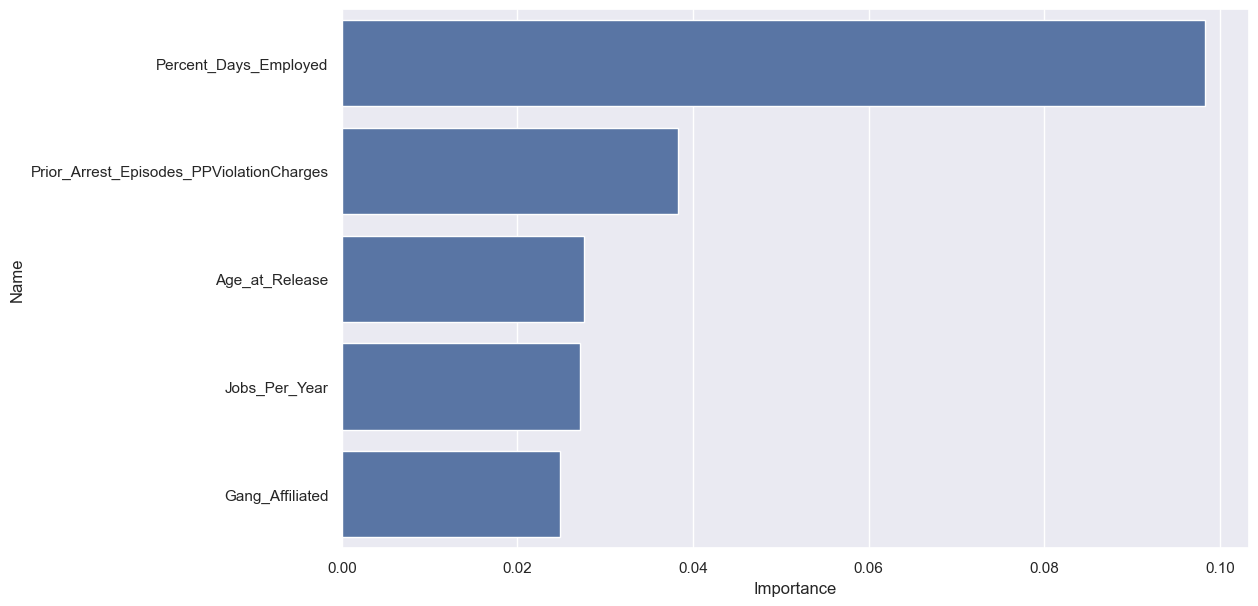

In [29]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out["importances_mean"], "STD": out["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now, use Permutation Feature Importance on XGBoost.

**Hint:** this is a more complex model; if you find that this task is taking too long, you may consider reducing the number of permutations using the parameter `n_repeats`. Be aware that this produces more variable results.

#### XGBoost Model:

<Axes: xlabel='Importance', ylabel='Name'>

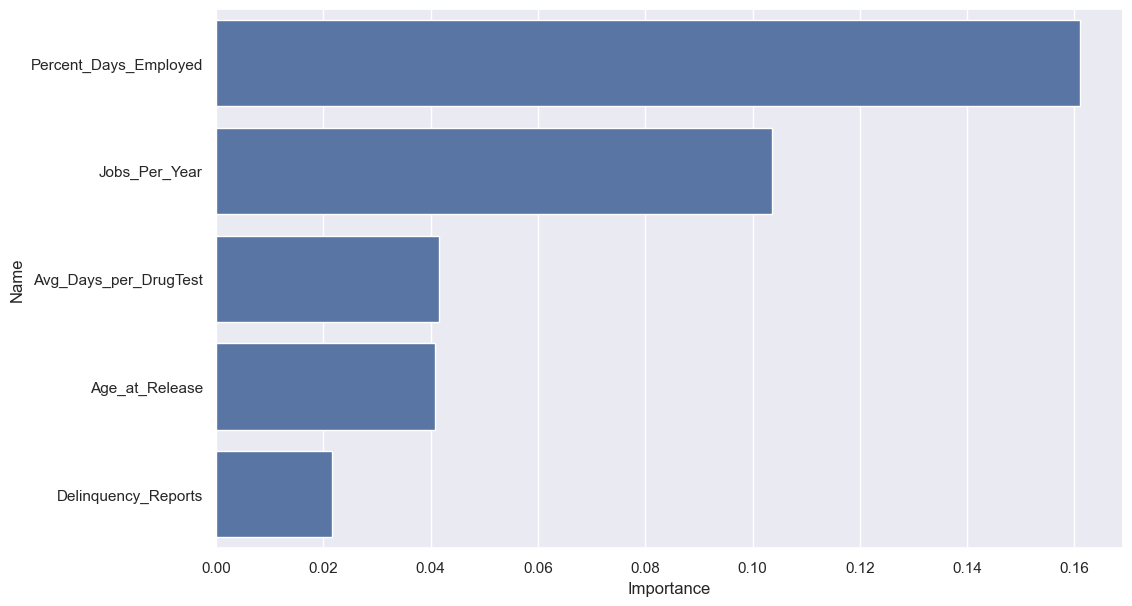

In [113]:
out_2 = permutation_importance(xgboost_model, X_train, y_train, n_repeats=10, random_state=123)

result_2 = pd.DataFrame({"Name": X_test.columns, "Importance": out_2["importances_mean"], "STD": out_2["importances_std"]})
result_2 = result_2.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result_2[:5], y="Name", x="Importance")

Now that you have completed your analysis of feature importance using permutation, comment on the results. How do the sets of most important features compare with each other? Are this results similar to what you observed using the surrogate model?

<span style="color:blue">`Percent_Days_Employed`, `Age_at_Release` and `Jobs_Per_Year` are features that are highly important to both `rf_model` and `xgboost_model`. `Percent_Days_Employed` is the most important feature in both models, which is similar to how their corresponding surrogate models and `logreg_model` provide a very large negative coefficient for `Percent_Days_Employed`. `Age_at_Release` has more importance in `xgboost_model` than in `rf_model`, and both of their corresponding surrogate models along with `logreg_model` often provide large coefficients for specific levels of `Age_at_Release`, with `pipeline-2__Age_at_Release_48 or older` in particular consistently having a large negative coefficient. `Jobs_Per_Year` has significantly greater importance in `xgboost_model` than in `rf_model`, yet the surrogate model for `xgboost_model` does not have the feature as among its greatest coefficients, while the feature has a large coefficient for `logreg_model` and the surrogate model of `rf_model`.
<br><br> 
The feature importance of `Prior_Arrest_Episodes_PPViolationCharges` in `rf_model` corresponds to the large negative coefficient of `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0` and the large positive coefficient of `pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more` from `surrogate_model_rf`, which are among the extreme levels for `Prior_Arrest_Episodes_PPViolationCharges`. The feature importance of `Prior_Arrest_Episodes_PPViolationCharges` in `rf_model` corresponds to the large positive coefficient of `pipeline-2__Gang_Affiliated_True` from `surrogate_model_rf`.
<br><br> 
The feature importance of `Avg_Days_per_DrugTest` in `xgboost_model` does not correspond to the features with particularly large coefficient values provided by `surrogate_model_xgboost`. The feature importance of `Delinquency_Reports` corresponds to the large negative coefficient for `pipeline-2__Delinquency_Reports_4 or more` and the large positive coefficient for `pipeline-2__Delinquency_Reports_1` from `surrogate_model_xgboost`, which are among the extreme levels for `Delinquency_Reports`.
</span>

### Question 13: Evaluation of Non-inherently Interpretable Models Using SHAP

The last method we are going to use to interpret the impact of each feature in our model is called SHAP, which stands for SHapley Additive exPlanations. How SHAP works is beyond the scope of this course, but if you are curious you can read the [original paper](https://arxiv.org/pdf/1705.07874.pdf) by Lundberg and Lee and check out [Lundberg's GitHub repo](https://github.com/shap/shap), which provides details on the implementation and examples.

You will need to install SHAP to be able to use it:
```
pip install shap
or
conda install -c conda-forge shap
```

Then, import it:

In [30]:
# !pip install shap
import shap # downgrade numpy to version = 1.23
shap.initjs()

SHAP needs the model (we will start with Random Forest) and samples to use to explain the predictions. For this, we will need to give it transformed samples (scaled and imputed, as required by the model) from  `X_train` or `X_test`.

In [31]:
X_train_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
# This line just gives 1000 random indexes from the training set
# We do this because getting SHAP values for all samples would be a bit too long, but you 
# are free to try it out!

ind = np.append(ind, 106) # adding the hard sample - we'll need this later

The following lines are all that's needed to explain the model's predictions for a set of samples:

In [32]:
rf_explainer = shap.Explainer(rf_model[-1])  # creating SHAP Explainer based on the model

# rf_shap_values = rf_explainer(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples
rf_shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind])

In [33]:
display(rf_shap_values[:,:,1])
# display(rf_shap_values.values)
# display(rf_shap_values_plot)

array([[ 1.06719094e-02, -5.48216626e-02, -3.13233805e-03, ...,
        -1.37421811e-03, -3.15218512e-04, -4.01205505e-04],
       [ 6.14137029e-03,  2.19969500e-02, -1.72943403e-03, ...,
        -1.07619867e-03,  1.74957837e-05, -6.96115059e-04],
       [ 7.76597396e-03, -2.84718017e-02, -5.65477939e-03, ...,
        -8.36543698e-04, -3.92228806e-04, -4.34920690e-04],
       ...,
       [-5.79775844e-04,  3.52063777e-02, -8.99642564e-03, ...,
         5.33796839e-03,  3.14791008e-04,  6.87036751e-04],
       [ 2.08119648e-03,  3.70484252e-02,  3.71094587e-02, ...,
        -1.26306106e-03,  1.99289952e-04, -3.15545879e-04],
       [-3.94334448e-03,  8.21011060e-03, -4.81923980e-03, ...,
        -7.63568655e-04,  3.85609483e-04,  3.01598369e-03]])

This gives us the SHAP values for each sample and each feature (the index 1 indicates the positive class):

This is hardly interpretable, though. It is better to get the average values for each feature, which returns something similar to feature importance:

In [34]:
# values = np.abs(rf_shap_values.values).mean(0)
values = np.abs(rf_shap_values[:,:,1]).mean(0)
values

array([0.00638426, 0.02600899, 0.00915188, 0.02391101, 0.00489305,
       0.01267705, 0.00429172, 0.07183361, 0.0214955 , 0.00739506,
       0.00212438, 0.00631662, 0.0093099 , 0.00273229, 0.00117365,
       0.00126914, 0.00211514, 0.01642745, 0.0291434 , 0.00389147,
       0.00196468, 0.00716819, 0.00501335, 0.00407194, 0.00142192,
       0.00138502, 0.00121101, 0.00108691, 0.00132543, 0.001697  ,
       0.00085707, 0.0033805 , 0.00095303, 0.00135083, 0.00250134,
       0.00193764, 0.01069571, 0.00755889, 0.00040934, 0.00670786,
       0.00783043, 0.00201162, 0.00109894, 0.00073988, 0.00075517,
       0.00067163, 0.00070941, 0.00069601, 0.000518  , 0.00454799,
       0.00122947, 0.00092458, 0.00092099, 0.00080365, 0.00060278,
       0.00979816, 0.00201641, 0.0011758 , 0.0011223 , 0.00109634,
       0.01191835, 0.00146744, 0.00092111, 0.00084271, 0.00087978,
       0.00559776, 0.00164439, 0.00111819, 0.00107752, 0.00101269,
       0.0005281 , 0.0009472 , 0.0208794 , 0.00255508, 0.00082

In [35]:
# pd.DataFrame(data=values[:, 0], index=feature_names, columns=["SHAP"]).sort_values(
#     by="SHAP", ascending=False
# )[:10]
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.071834
pipeline-2__Gang_Affiliated_True,0.029143
pipeline-1__Supervision_Risk_Score_First,0.026009
pipeline-1__DrugTests_THC_Positive,0.023911
pipeline-1__Jobs_Per_Year,0.021495
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,0.020879
pipeline-2__Age_at_Release_48 or older,0.016427
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,0.016422
pipeline-2__Prior_Conviction_Episodes_Misd_0,0.013297
pipeline-1__DrugTests_Meth_Positive,0.012677


The SHAP library also has a lot of ways to visualize and interpret the SHAP values - try it out!

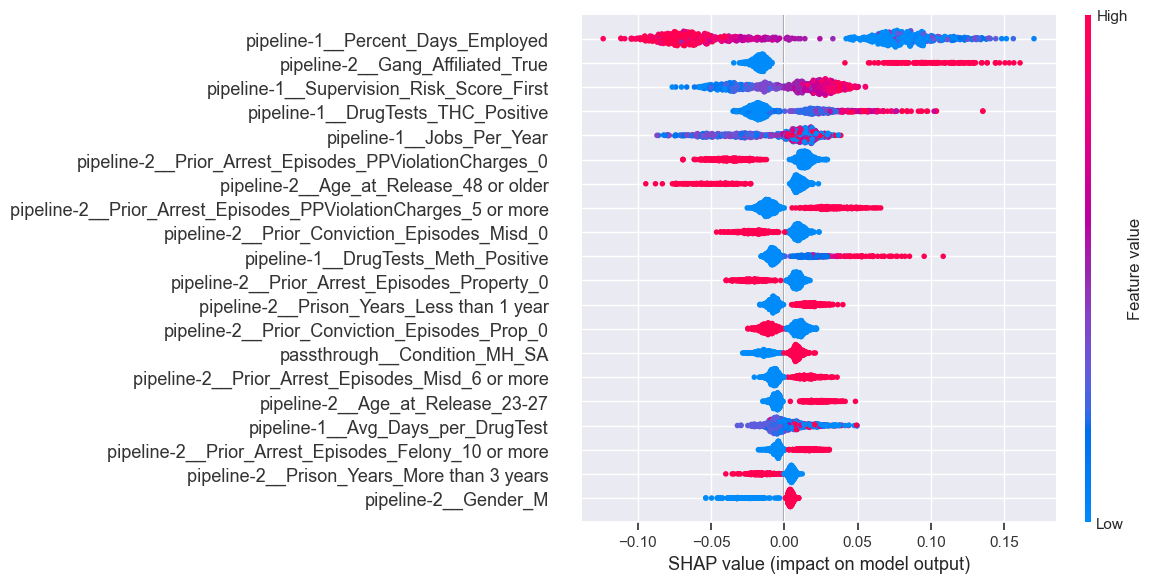

In [36]:
shap_figure = shap.summary_plot(rf_shap_values[:,:,1], X_test_enc.iloc[ind], plot_size=[12,6])
# shap_figure = shap.summary_plot(rf_shap_values[1], X_test_enc.iloc[ind], plot_size=[12,6])
# shap_figure = shap.summary_plot(rf_shap_values.values, X_test_enc.iloc[ind], plot_size=[12,6])
# shap.plots.beeswarm(rf_shap_values[:,:,1])

Given the new information obtained using the SHAP library on the Random Forest model, explain the results (you will need to refer to the SHAP documentation - or ask us for help interpreting the plots) and comment on the difference between these results and those obtained using the other methods.


<span style="color:blue">TEXT</span>

Next, **repeat this analysis for XGBoost.**

In [122]:
# Your answer here
xgboost_explainer = shap.Explainer(xgboost_model[-1])  # creating SHAP Explainer based on the model
xgboost_shap_values = xgboost_explainer.shap_values(X_test_enc.iloc[ind]) # explaining predictions for 1000 random samples
xgboost_shap_values

array([[ 6.09766059e-02, -3.27851504e-01,  5.23546450e-02, ...,
        -1.16608460e-02, -2.42378702e-03, -1.07992990e-02],
       [ 1.80289030e-01,  1.11031592e-01, -2.68283170e-02, ...,
        -1.60398185e-02, -1.17568974e-03,  1.88770378e-03],
       [ 6.60442635e-02, -2.26663843e-01, -2.62550801e-01, ...,
        -2.13722140e-02,  1.43574120e-03, -3.92168900e-03],
       ...,
       [ 7.62566030e-02,  1.32187068e-01, -1.51326537e-01, ...,
        -2.33977549e-02, -2.60472036e-04,  1.51977055e-02],
       [-6.34565055e-02,  8.85033980e-02,  1.76640779e-01, ...,
        -6.98049227e-03, -1.37500896e-03, -3.62958899e-03],
       [-8.36827010e-02,  8.97366777e-02, -2.91231066e-01, ...,
        -1.32905040e-02,  5.29078301e-03,  1.64071135e-02]], dtype=float32)

In [123]:
xgboost_values = np.abs(xgboost_shap_values).mean(0)
xgboost_values

array([6.88780174e-02, 1.12860046e-01, 1.96550190e-01, 1.30667597e-01,
       3.48946154e-02, 1.37540027e-01, 2.77172588e-02, 7.47321367e-01,
       4.90013659e-01, 1.11303538e-01, 4.26133946e-02, 7.35677928e-02,
       1.03394650e-01, 3.41746211e-02, 8.13516136e-03, 2.27606706e-02,
       3.01501527e-02, 1.34019539e-01, 1.95496961e-01, 1.20536964e-02,
       1.06466906e-02, 5.33290021e-02, 1.25278346e-02, 6.37941062e-02,
       1.16996206e-02, 3.10020577e-02, 8.04257393e-03, 5.96803147e-03,
       2.15159934e-02, 7.15789013e-03, 4.85711452e-03, 1.11923618e-02,
       1.00099994e-02, 7.77149759e-03, 1.17195183e-02, 4.00372334e-02,
       5.51111512e-02, 3.48622501e-02, 4.44094324e-03, 5.73060587e-02,
       6.36330619e-02, 1.65530313e-02, 1.07979923e-02, 5.54680964e-03,
       1.29981469e-02, 1.06642358e-02, 8.77476390e-03, 1.42549723e-02,
       2.71114684e-03, 3.89048830e-02, 1.17025692e-02, 8.82751960e-03,
       7.03641446e-03, 2.24635098e-02, 3.15472507e-03, 7.47137964e-02,
      

In [124]:
pd.DataFrame(data=xgboost_values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.747321
pipeline-1__Jobs_Per_Year,0.490014
pipeline-1__Avg_Days_per_DrugTest,0.196550
pipeline-2__Gang_Affiliated_True,0.195497
passthrough__Condition_MH_SA,0.141301
pipeline-1__DrugTests_Meth_Positive,0.137540
pipeline-2__Age_at_Release_48 or older,0.134020
pipeline-1__DrugTests_THC_Positive,0.130668
pipeline-1__Supervision_Risk_Score_First,0.112860
pipeline-2__Gender_M,0.111304


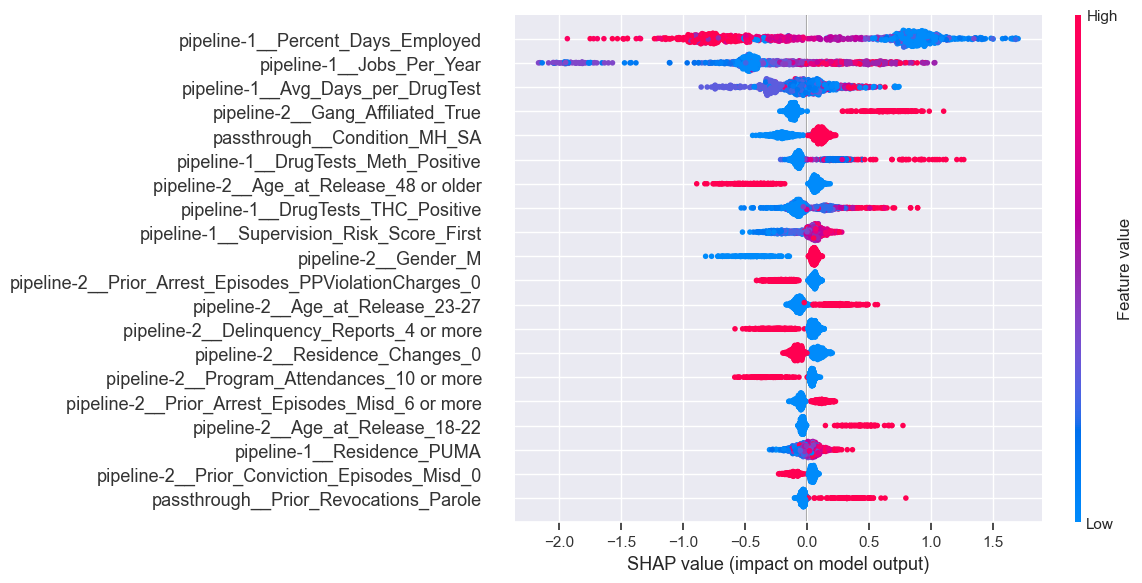

In [125]:
shap_figure = shap.summary_plot(xgboost_shap_values, X_test_enc.iloc[ind], plot_size=[12,6])

<span style="color:blue">TEXT</span>

### Question 14: Explaining individual predictions using SHAP

Another powerful feature of SHAP is that it allows us to explain the impact of each feature on individual predictions. For example, we will be able to explain how the prediction for our hard sample was generated. Let's start by looking at the prediction for this sample given by the random forest model. **Is it correct?**

In [126]:
# Your answer here: The classification is incorrect
display(y_test[106:107]) # False
display(rf_model.predict(hard_sample)) # True

106    False
Name: Recidivism_Within_3years, dtype: bool

array([ True])

Let's look at the **force plot** for this particular prediction, by running the cell below:

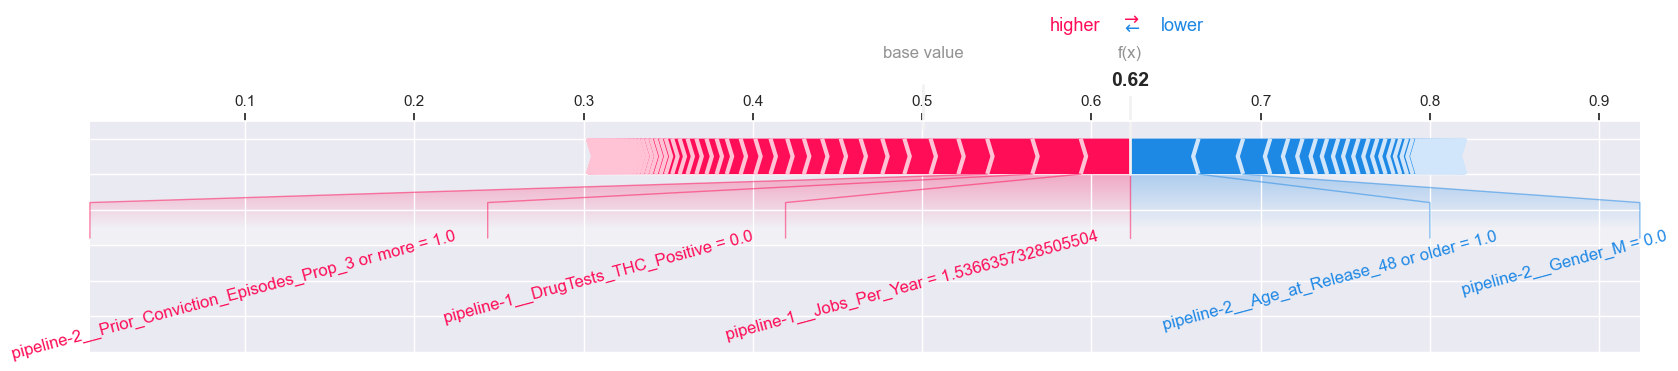

In [142]:
# shap.force_plot(
#     rf_explainer.expected_value[1],
#     rf_shap_values[1][-1],
#     X_test_enc.iloc[ind[-1]],
#     matplotlib=True,
# )

shap.force_plot(
    rf_explainer.expected_value[1],
    rf_shap_values[:,:,1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
    figsize=(20, 3), 
    text_rotation=15,
)

**Interpret the plot results,**, including the following:
- What contributed the most to the prediction?
- What countered the prediction the most?
- Can we tell, by looking at the plot, that this was a difficult prediction?

* <span style="color:blue">TEXT</span>

Finally, **repeat the analysis and comment on the results of the individual predictions made on the hard sample by XGBoost and Decision Tree** (since we were not able to do the latter earlier).

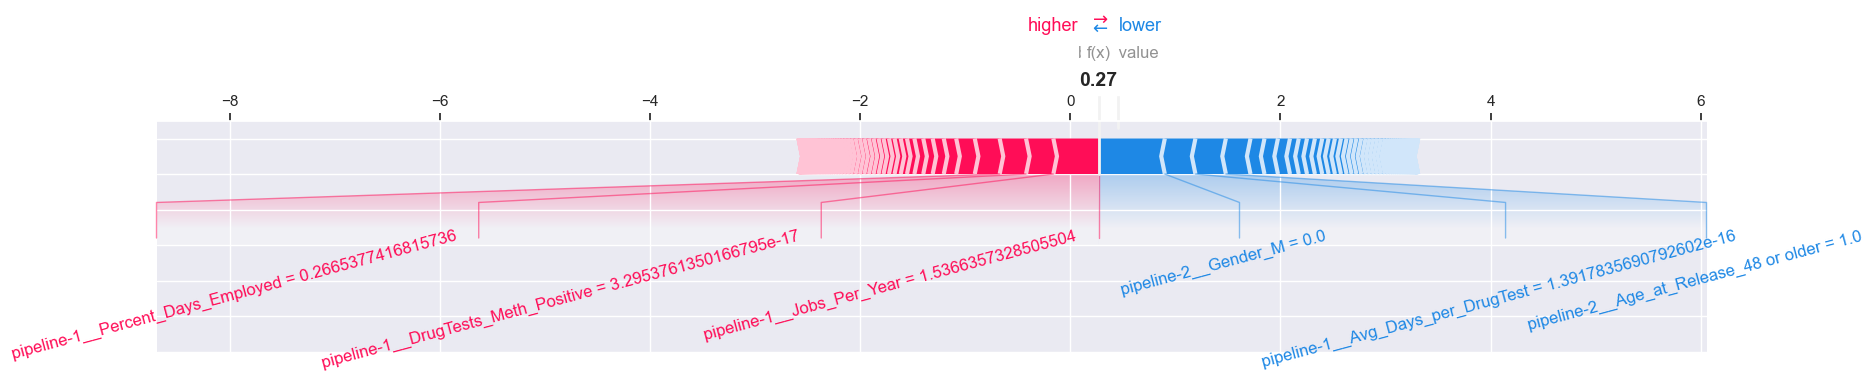

In [134]:
# Your answer here
shap.force_plot(
    xgboost_explainer.expected_value,
    xgboost_shap_values[-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
    figsize=(20, 3), 
    text_rotation=15,
)

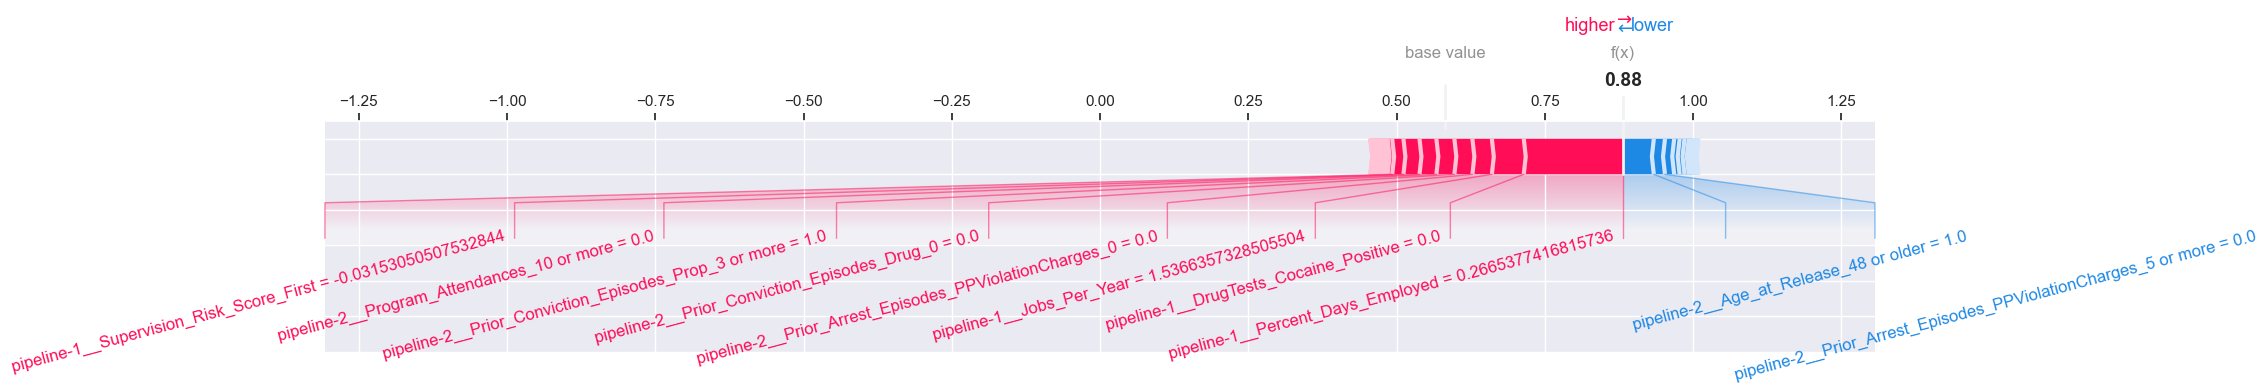

In [140]:
tree_explainer = shap.Explainer(tree_model[-1])  # creating SHAP Explainer based on the model
tree_shap_values = tree_explainer.shap_values(X_test_enc.iloc[ind]) # explaining predictions for 1000 random samples
# tree_shap_values[:,:,1]
shap.force_plot(
    tree_explainer.expected_value[1],
    tree_shap_values[:,:,1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
    figsize=(20, 3), 
    text_rotation=15,
)

* <span style="color:blue">TEXT</span>

# Part 5: Final Evaluation:

### Question 15

Using **all the results collected so far** on accuracy, fairness and transparency of the 5 models, write your recommendation about what model, in your opinion, should be employed for this application (300 words max).

<span style="color:blue">TEXT</span>

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

* <span style="color:blue">Jingyuan's response: </span>
* <span style="color:blue">Nicholas' response: Completed outline for Q1-3, worked on the </span>

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

* <span style="color:blue">Jingyuan's response: </span>
* <span style="color:blue">Nicholas' response: Used ChatGPT to help with fixing errors in environment, </span>

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

* <span style="color:blue">Jingyuan's response: </span>
* <span style="color:blue">Nicholas' response: </span>